# Wassertein Distance

## Importing libraries

In [1]:
import numpy as np
from scipy import stats
import scipy as sp
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use("science")
import cvxpy as cp
import math
import matplotlib as mpl
from random import shuffle
import pandas as pd
import networkx as nx
from scipy import optimize

## Distances between distributions

Let
- ($\Omega_{X}$, $F_{X}$, $\mu$) and ($\Omega_{Y}$, $F_{Y}$, $\nu$) be two probability spaces
- $X: \Omega_{X} \rightarrow \mathbb{R}$ and $Y: \Omega_{Y} \rightarrow \mathbb{R}$ two random variables on the same domain D

In [2]:
data = pd.read_csv("../datasets/gaussians.csv")
x = data["x"]
y = data["y"]
n = y.size
assert(n == x.size)

In [3]:
def plot_gaussians(x, y):
    fig, ax = plt.subplots(figsize=(5, 3))
    dmax = (y - x).abs()
    z = x
    for k in range(2, 7):
        plt.plot(z + dmax / k, color = "silver")
    for k in range(2, 6):
        plt.plot(z + k*dmax / (k+1), color = "silver")
    ax.plot(range(n), x, color = "darkblue", label = r"$\mu$")
    ax.plot(range(n), y, color = "darkred", label = r"$\nu$")
    ax.set_title("Two gaussian distributions")
    plt.legend()
    plt.show()

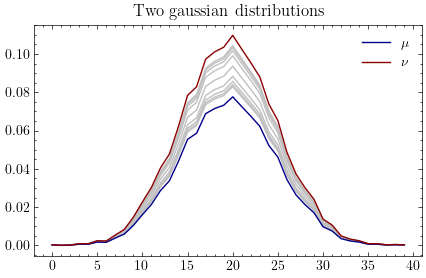

In [4]:
plot_gaussians(x, y)

**Total variation of probabilty measures**

$$
\delta(\mu, \nu) = \sup_{X \times Y} |\mu(x) - \nu(y)| = \dfrac{1}{2} \int_{X \times Y}|\mu(x) - \nu(y)|d\gamma(x,y) : 
\gamma \in \Gamma(\mu, \nu)
$$

In [5]:
.5 * (x - y).abs().sum()

0.20710678118654674

**Hellinger**

$$
\sqrt( \int_{X \times Y} (\sqrt \mu(x) - \sqrt \nu(y))^2)d\gamma(x,y) : \gamma \in \Gamma(\mu,\nu)
$$

In [6]:
np.sqrt( np.sum( (np.sqrt(x) - np.sqrt(y))**2 ) )

0.18920711500272036

**L2**

$$
\int_{X \times Y} (\mu(x) - \nu(y))^2 d\gamma(x,y) : \gamma \in \Gamma(\mu, \nu)
$$

In [7]:
np.sum((x - y)**2)

0.00923557228183476

**$\chi_2$**

$$
\int_{X \times Y} \dfrac{ (\mu(x) - \nu(x))^2 }{\nu(x)} d\gamma(x,y) : \gamma \in \Gamma(\mu, \nu)
$$

In [8]:
np.sum((x - y)**2/(y + 1e-5))

0.12128711429109887

## Wasserstein distance

Let $p \in [0, +\infty)$

The wasserstein distance of order p between $\mu$ and $\nu$ is :

<font color="blue">
$$
\begin{align*}
\mathbf{W}_{p}(\mu, \nu) &= \left( \frac{\inf}{\gamma \in \mathbf{\Gamma}(\mu, \nu)} 
    \int_{\mathbf{X}x\mathbf{Y}} d(x, y)^p  d\gamma(x,y) \right)^{1/p} \\
    &= \left( \dfrac{inf}{\gamma \in \Gamma(\mu, \nu)} \mathbb{E}_{(x,y) \sim \gamma} d(x,y)^p \right)^{1-p}
\end{align*}
$$
</font>

- $\gamma$ is a coupling of $\mu$ and $\nu$
- $\Gamma(\mu, \nu)$ is the set of all couplings of $\mu$ and $\nu$

for $p=1$, the first wasserstein distance is
$$
\mathbf{W}_p = \frac{inf}{\gamma \in \Gamma(\mu, \nu)} \int_{X \times Y} d(x, y)d\gamma(x,y) =
\dfrac{1}{n} \sum_{X \times Y} |x - y|
$$

In [9]:
1/n * np.sum((x - y).abs())

0.010355339059327338

for $p=2$, the second wasserstein distance is
$$
\mathbf{W}_p = (\frac{inf}{\gamma \in \Gamma(\mu, \nu)} \int_{X \times Y} d(x, y)^2d\gamma(x,y))^{1/2} =
(\dfrac{1}{n} \sum_{X \times Y} |x - y|^2)^{1/2}
$$

In [10]:
(1/n * np.sum(np.square(x - y)))**0.5

0.015195042186380037

## Wasserstein distance in high dimensions

In high dimensions, the wasserstein distance is defined by

<font color="blue">
$$
\begin{align*}
\mathbf{W}_{p}(\mu, \nu) &= \left( \frac{\inf}{\pi \in \mathbf{\Pi}_N} 
    \dfrac{1}{N} \sum_{i=1}^{N} \| x_i - y_{\pi_i} \| ^{p} \right)^{1/p}
\end{align*}
$$
</font>

where

- $\Pi_N$ is the set of permutations of $\{ 1, 2, ..., N \}$
- $\pi_i$ if a permutation in $\Pi_N$

It can be solved with a linear asignment algorithm

**Sample from gaussians in 2d**

In [11]:
def random_gaussian(mean = np.ones(2), std = np.eye(2)):
    return stats.multivariate_normal(mean, std)

In [12]:
rvx = random_gaussian([0.1, 0.3])
rvy = random_gaussian(np.array([5., 5.]))

In [13]:
def sample_gaussian(rv, n):
    s = np.zeros((n, 2))
    for i in range(n):
        s[i,:] = rv.rvs()
    spdf = np.array([rv.pdf(s[i,:]) for i in range(n)])
    return s, spdf

In [14]:
n = 1000

In [15]:
x, xpdf = sample_gaussian(rvx, n)

In [16]:
y, ypdf = sample_gaussian(rvy, n)

**Scatter plot**

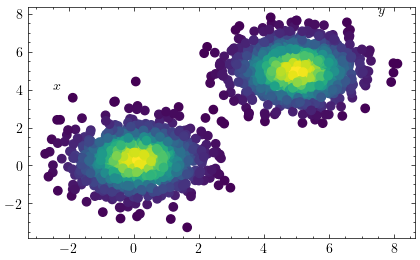

In [17]:
fig, ax = plt.subplots(figsize = (5, 3))
plt.scatter(x[:, 0], x[:, 1], c = xpdf)
plt.scatter(y[:, 0], y[:, 1], c = ypdf)
plt.annotate(r"$x$", (-2.5, 4.))
plt.annotate(r"$y$", (7.5, 8.))
plt.show()

**Contour plot**

In [18]:
def contour_values(rv, s, spdf):
    cx = s[:, 0].copy()
    cy = s[:, 1].copy()
    ca, cb = np.meshgrid(cx, cy)
    c = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            c[i, j] = rv.pdf(np.array([ca[i, j], cb[i,j]]))
    return cx, cy, c

In [19]:
xa, xb, xc = contour_values(rvx, x, xpdf)

In [20]:
ya, yb, yc = contour_values(rvy, y, ypdf)

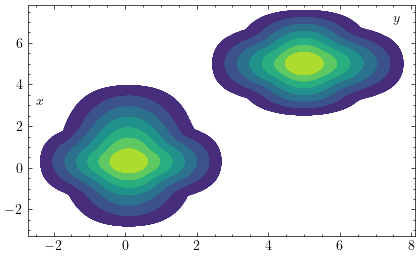

In [21]:
fig, ax = plt.subplots(figsize = (5, 3))
plt.contour(xa, xb, xc)
plt.contour(ya, yb, yc)
plt.annotate(r"$x$", (-2.5, 3.))
plt.annotate(r"$y$", (7.5, 7.))
plt.show()

### Cost matrix

In [22]:
c = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        c[i, j] = np.sqrt((x[i][0] - y[j][0])**2 + (x[i][1] - y[j][1])**2)

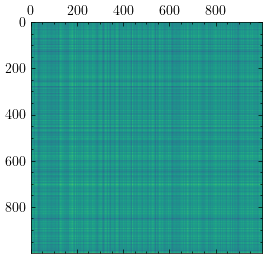

In [23]:
fig, ax = plt.subplots(figsize = (3, 3))
ax.matshow(c, interpolation = "bilinear")
plt.show()

### Bipartite graph formulation

In [24]:
g = nx.Graph()

In [25]:
nodex = ['x' + str(_x) for _x in list(range(n))]
nodey = ['y' + str(_y) for _y in list(range(n))]

In [26]:
for i in range(n):
    g.add_node(nodex[i])
for j in range(n):
    g.add_node(nodey[j])

In [27]:
for i in range(n):
    for j in range(n):
        g.add_edge(nodex[i], nodey[j], weight=c[i, j])

In [28]:
sol = nx.bipartite.minimum_weight_full_matching(g)

In [29]:
min_cost = 0.
for src, dest in sol.items():
    min_cost += g.get_edge_data(src, dest)['weight']
min_cost /= 2
print("Minimum cost: {:.2f}".format(min_cost))

Minimum cost: 6774.19


In [30]:
r = np.zeros((n, 2), np.int32)

In [31]:
k = 0
for nodei,nodej in sol.items():
    r[k, 0] = int(nodei[1:])
    r[k, 1] = int(nodej[1:])
    k += 1
    if (k == n):
        break

The Wasserstein distance is

In [32]:
w_graph = 0.
for k in range(n):
    i = r[k, 0]
    j = r[k, 1]
    w_graph += np.sqrt((x[i][0] - y[j][0])**2 + (x[i][1] - y[j][1])**2)
w_graph /= n
w_graph = w_graph ** 0.5

In [33]:
w_graph

2.602726523100742

### Hungarian algorithm

The hungarian algorithm, an $O(n^3)$ solution for the linear assignment problem is implemented in scipy

In [34]:
match = optimize.linear_sum_assignment(c)

In [35]:
w_hungarian = 0.
for k in range(n):
    i = match[0][k]
    j = match[1][k]
    w_hungarian += np.sqrt((x[i][0] - y[j][0])**2 + (x[i][1] - y[j][1])**2)
w_hungarian /= n
w_hungarian = w_hungarian ** 0.5

In [36]:
w_hungarian

2.602726523100741

## References